In [1]:
#Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from multiprocessing import Pool


import torchvision
from torchvision import models as tvmodels
from torchsummary import summary

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

import torchvision.models as torchvisionmodels

import os
import numpy as np
import cv2
import argparse
import sys

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import itertools
import more_itertools

import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

from captum.attr import LayerGradCam
from captum.attr import visualization
from PIL import Image
import shutil

import numpy as np
from dask_image.imread import imread
from dask_image import ndfilters, ndmorph, ndmeasure
import matplotlib.pyplot as plt
from dask_image import ndmeasure

from operator import itemgetter

In [7]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
from time import time
from typing import Callable, Tuple, List
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from math import sqrt, ceil, floor
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch
from mnist_training.trainer import *

allowed_classes = [1, 7]
labels_map = {
    0: '1',
    1: '7',
}

batch_size = 128

model = MNIST_model(len(allowed_classes))
checkpoint = torch.load('mnist_training/training_saves/model_MNIST_71.pt')
model.load_state_dict(checkpoint["MODEL_STATE"])

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data, valid_data, test_data = create_dataloaders_MNIST(batch_size, allowed_classes)

model.to(device)
model.eval()
print("Model and data loaded")

RuntimeError: Dataset not found. You can use download=True to download it

In [2]:
from model import resnet
from model.utils import load_filtered_state_dict, SaveBestModel, AverageMeter, accuracy
model = resnet.ResNet(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], 2)
checkpoint = torch.load('cyberbullying-pytorch/models/cyberbullying/epoch_8.pkl')
load_filtered_state_dict(model, checkpoint, ignore_layer=[], reverse=True)
transform_test = transforms.Compose([transforms.Resize(320),
        transforms.CenterCrop(299), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

good_img_transform = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

classes = {0:'cyberbullying', 1:'non_cyberbullying'}

test_path = 'cyberbullying/test'
testset = torchvision.datasets.ImageFolder(test_path, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=16, shuffle=True, num_workers=2)

model.to(device)
model.eval()
print("Model and data loaded")
#model.load_state_dict(checkpoint, strict=False)

320 320
Model and data loaded


In [3]:
# This is to reverse the normalization done to the images that centered them around imagenet mean and std
# The invTrans should be used on images before saving them.
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [4]:
from skimage import segmentation
from pytorch_grad_cam import XGradCAM, GradCAM, FullGrad, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from skimage.segmentation import slic, felzenszwalb, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import sobel

In [5]:
def get_grayscale_grad_cam(image):
    input_tensor = image.to(device)
    targets = [ClassifierOutputTarget(0)]
    #target_layers = [model.layer4[-1]]
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    return(grayscale_cam)

def segmentation_info(image, num_segments, compactness):
    img_np = image.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    segments_slic = slic(img_np, n_segments = num_segments, compactness=compactness,
                     start_label=1)
    num_segments = len(np.unique(segments_slic))
    list_unique_regions = np.unique(segments_slic)
    segment_pixel_num_list = []
    total_pixels = 0
    for i in (list_unique_regions):
        num_pixels = np.count_nonzero(segments_slic == i)
        segment_pixel_num_list.append(num_pixels)
        total_pixels += num_pixels
    
    
    information_for_each_segment = []
    for i in (list_unique_regions):
        image_list = []
        image_list.append(i)
        image_list.append(segment_pixel_num_list[i-1])
        image_list.append(total_pixels)
        information_for_each_segment.append(image_list)

    return(information_for_each_segment, segments_slic, num_segments)


# I want to get the average attribution score for each segment
def cam_processor_for_segments(grayscale_cam_output, segments_slic):
    
    
    
    list_unique_regions = np.unique(segments_slic)
    region_attr_score = []
    final_region_attr_score = []
    num_pixels_in_region_list = []
    
    for i in (list_unique_regions):
        row_counter = 0
        column_counter = 0
        region_attr_score = []
        num_pixels_in_region = 0
        for row in grayscale_cam_output:
            for cell in row:
                current_score = grayscale_cam_output[row_counter, column_counter]
                current_region = segments_slic[row_counter, column_counter]
                if current_region == i:
                    region_attr_score.append(current_score)
                    num_pixels_in_region += 1
                column_counter +=1
            row_counter += 1
            column_counter = 0
        avg_score = np.mean(region_attr_score)
        final_region_attr_score.append(avg_score)
        num_pixels_in_region_list.append(num_pixels_in_region)
    
    unique_region_info = []
    for i in (list_unique_regions):
        image_list = []
        image_list.append(i)
        image_list.append(final_region_attr_score[i-1])
        image_list.append(num_pixels_in_region_list[i-1])
        image_list.append(np.sum(num_pixels_in_region_list))
        unique_region_info.append(image_list)
    
    return(unique_region_info)


def get_feature_masks(image, attributions, segments_slic):
    segments_slic_1 = segments_slic
    features = []
    for i in attributions:
        feature = np.where(i==segments_slic_1, 1, 0)
        features.append(feature)
        
    return(features)


def attribution_ranker(cam_processor_for_segments_output, num_top_attr):
    ranked_images = sorted(cam_processor_for_segments_output, key=itemgetter(1), reverse=True)
    top_ranked_features = []
    for i in range(num_top_attr):
        top_ranked_features.append(ranked_images[i][0])
        
    return top_ranked_features

def get_image_versions(image, features_list, model, SMU_class_index):
    image_versions = []
    num_pixels_changed = []
    total_attr_list = []

    powerset_list = list(more_itertools.powerset(features_list))
    powerset_list = [list(ele) for ele in powerset_list]
    num_versions = len(powerset_list)
    
    original_image = invTrans(image)
    image_versions.append(original_image)
    num_pixels_changed.append(0)
    total_attr_list.append(np.zeros((299, 299)))
    
    for version in range(num_versions - 1):
        obfuscated_image = image
        total_attribution = np.zeros((299, 299))
        total_num_pixels = total_attribution.size
        for mask in range(len(powerset_list[version + 1])):
            total_attribution += powerset_list[version + 1][mask]
            #print(np.max(powerset_list[version + 1][mask]))
        #print(np.max(total_attribution))
        num_changes = np.count_nonzero(total_attribution)
        num_pixels_changed.append(num_changes)
        total_attr_list.append(total_attribution)
        #print(num_changes)
        obfuscated_image = blur_image_from_attribution(image = obfuscated_image,
                                                       attribution_map = total_attribution)
        obfuscated_image = obfuscated_image.to(device)
        obfuscated_image = invTrans(obfuscated_image)
        
        image_versions.append(obfuscated_image)
    
    scores = []
    for i in range(num_versions):
        current_image = image_versions[i].to(device)
        #current_image = good_img_transform(current_image).to(device)
        score = SMU_cost_function(num_total_pixels = total_num_pixels,
                                  num_obf_pixels = num_pixels_changed[i],
                                  model = model,
                                  image = current_image,
                                  SMU_class_index = SMU_class_index)
        scores.append(score)
    
    
    
    unique_image_info = []
    for i in range(num_versions):
        image_list = []
        image_list.append(image_versions[i])
        image_list.append(num_pixels_changed[i])
        image_list.append(total_num_pixels)
        image_list.append(scores[i])
        image_list.append(total_attr_list[i])
        unique_image_info.append(image_list)
    
    
    return(unique_image_info)


def image_rankings(get_image_versions):
    #for idx in iterative_Grad_CAM_counterfactual_masking_output
    ranked_images = sorted(get_image_versions, key=itemgetter(3))
    
    return ranked_images

def blur_image_from_attribution(image, attribution_map):
    # attribution map is the attributions after being passed through the attribution processor
    # image is a tensor
    # will output the blurred image based on the attribution map
    
    
    #average_img = image.squeeze().cpu().permute(1, 2, 0).numpy()
    #avg = np.average(average_img)
    #blurred_img = cv2.GaussianBlur(image.squeeze().cpu().permute(1, 2, 0).numpy(), (181, 181), 0)
    avg = np.float32(-2.1179039478302)
    #avg_img = np.where(average_img > 9999, average_img, avg)
    
    #attribution_map = attribution_map.detach().squeeze().cpu().numpy()
    
    mask = [attribution_map, attribution_map, attribution_map]
    mask = np.array(mask)
    mask = mask.transpose(1,2,0)
    
    out = np.where(mask==np.array([0, 0, 0]), image.squeeze().cpu().permute(1, 2, 0).numpy(), avg)
    #out = np.where(mask==np.array([0, 0, 0]), image.squeeze().cpu().permute(1, 2, 0).numpy(), blurred_img)
    
    out = torch.tensor(out)
    out = out.permute(2,0,1)
    out = out.unsqueeze(0)
    
    return out

def SMU_cost_function(num_total_pixels, num_obf_pixels, model, image, SMU_class_index):
    image = good_img_transform(image)
    logits = model(image).cpu()
    probs = F.softmax(logits, dim=1)
    probs = probs.detach().cpu()
    probs = probs.tolist()[0]
    probs = probs[SMU_class_index]
    
    if num_obf_pixels == 0:
        score = 1000
    
    else:
        # Punish for prob too far from 0.5. We want to obfuscate just enough to change model prediction
        score = probs + (num_obf_pixels / num_total_pixels)
    
    if probs > 0.50:
        score += 1
    if probs > 0.75:
        score += 1
    if probs > 0.80:
        score += 10**(1+probs)
    #print(probs)
    return score

def full_obfuscation_function(image, num_segments, num_top_attr, compactness, model, SMU_class_index):
    example_10 = get_grayscale_grad_cam(image = image)
    seg = segmentation_info(image = image, num_segments = num_segments, compactness = compactness)
    avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = example_10, segments_slic = seg[1])
    top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = num_top_attr)
    features_1 = get_feature_masks(image = image, attributions = top_attrs, segments_slic = seg[1])
    ex_1 = get_image_versions(image = image, features_list = features_1, model = model, SMU_class_index = SMU_class_index)
    ranked = image_rankings(get_image_versions = ex_1)
    
    return ranked


In [23]:
def segmentation_info_slic(image, num_segments, compactness):
    img_np = image.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    segments_slic = slic(img_np, n_segments = num_segments, compactness=compactness,
                     start_label=1)
    num_segments = len(np.unique(segments_slic))
    list_unique_regions = np.unique(segments_slic)
    segment_pixel_num_list = []
    total_pixels = 0
    for i in (list_unique_regions):
        num_pixels = np.count_nonzero(segments_slic == i)
        segment_pixel_num_list.append(num_pixels)
        total_pixels += num_pixels
    
    
    information_for_each_segment = []
    for i in (list_unique_regions):
        image_list = []
        image_list.append(i)
        image_list.append(segment_pixel_num_list[i-1])
        image_list.append(total_pixels)
        information_for_each_segment.append(image_list)

    return(information_for_each_segment, segments_slic, num_segments)

def segmentation_info_felzenszwalb(image, scale, sigma, min_size):
    img_np = image.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    segments_felz = felzenszwalb(img_np, scale=scale, sigma=sigma, min_size=min_size)
    num_segments = len(np.unique(segments_slic))
    list_unique_regions = np.unique(segments_slic)
    segment_pixel_num_list = []
    total_pixels = 0
    for i in (list_unique_regions):
        num_pixels = np.count_nonzero(segments_slic == i)
        segment_pixel_num_list.append(num_pixels)
        total_pixels += num_pixels
    
    
    information_for_each_segment = []
    for i in (list_unique_regions):
        image_list = []
        image_list.append(i)
        image_list.append(segment_pixel_num_list[i-1])
        image_list.append(total_pixels)
        information_for_each_segment.append(image_list)

    return(information_for_each_segment, segments_slic, num_segments)



def softmax_score(num_total_pixels, num_obf_pixels, model, image, SMU_class_index):
    image = good_img_transform(image)
    logits = model(image).cpu()
    probs = F.softmax(logits, dim=1)
    probs = probs.detach().cpu()
    probs = probs.tolist()[0]
    probs = probs[SMU_class_index]

    return probs


    


def region_explainability(image, top_n_start, model, SMU_class_index):
    # Get attribution map
    explainability_mask = get_grayscale_grad_cam(image)
    # Get segment mask
    seg = segmentation_info_slic(image = image, num_segments = 100, compactness = 50)
    # Calculate average attribution in each superpixel
    avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = explainability_mask, segments_slic = seg[1])
    # Sort the regions by average attribution, make num_top_attr = the number of segments in the image
    top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = seg[2])
    features_1 = get_feature_masks(image = image, attributions = top_attrs, segments_slic = seg[1])
    # features_1 gives us a sorted list of feature masks. Element at position 0 is the top attribution region mask

    top_n = top_n_start
    score = 1000
    prob = 1
    
    # The computational cost of this loop could be reduced by approximately half
    # Currently I do a counterfactual analysis on top_n regions and expand top_n to top_n + 1
    # This implementation has us redo the counterfactual analysis of the top_n when doing counterfactual analysis on top_n + 1

    while prob > 0.5:
        #image_versions holds the image with regions obfuscated
        image_versions = []
        #num_pixels_changed holds the count of the number of pixels that are obfuscated
        num_pixels_changed = []
        #total_attr_list I think gives us the label of the regions that are being obfuscated
        total_attr_list = []
        #scores holds the score given to the image with regions obfuscated
        scores = []
        
        # features_list contains the features to be analyzed in counterfactual analysis
        # features_list will start with the top 1 region and then go on to top 2 and so on
        features_list = features_1[0:top_n]
        
        powerset_list = list(more_itertools.powerset(features_list))
        powerset_list = [list(ele) for ele in powerset_list]
        num_versions = len(powerset_list)
    
        original_image = invTrans(image)
        image_versions.append(original_image)
        num_pixels_changed.append(0)
        total_attr_list.append(np.zeros((299, 299)))
        
        
        
        for version in range(num_versions - 1):
            obfuscated_image = image
            total_attribution = np.zeros((299, 299))
            total_num_pixels = total_attribution.size
            for mask in range(len(powerset_list[version + 1])):
                total_attribution += powerset_list[version + 1][mask]
            num_changes = np.count_nonzero(total_attribution)
            obfuscated_image = blur_image_from_attribution(image = obfuscated_image,
                                                       attribution_map = total_attribution)
            obfuscated_image = obfuscated_image.to(device)
            obfuscated_image = invTrans(obfuscated_image)
        
            # calculate softmax score of obfuscated image on the unsafe image class
            score = softmax_score(num_total_pixels = total_num_pixels,
                                  num_obf_pixels = num_pixels_changed,
                                  model = model,
                                  image = obfuscated_image,
                                  SMU_class_index = SMU_class_index)
            #print(score)
            
            # if softmax score is less than 0.5, we want to save it as a counterfactual example
            if score < 0.5:
                prob = score
                image_versions.append(obfuscated_image)
                scores.append(score)
                num_pixels_changed.append(num_changes)
                total_attr_list.append(total_attribution)
        
        #print("Regions analyzed", top_n)
        top_n = top_n + 1
    
    
    # Creating an array to hold the information with each counterfactual image we generated
    # It is possible that we could have just one counterfactual image
    unique_image_info = []
    for i in range(len(scores)):
        image_list = []
        image_list.append(image_versions[i])
        image_list.append(num_pixels_changed[i])
        image_list.append(total_num_pixels)
        image_list.append(scores[i])
        image_list.append(total_attr_list[i])
        image_list.append(top_n)
        unique_image_info.append(image_list)
    
    
    # Rank the different counterfactual images
    ranked_images = image_rankings(get_image_versions = unique_image_info)
    
    # Get the best ranked image
    best_masked_image = ranked_images[0]
    
    return best_masked_image

Predicted class:  0


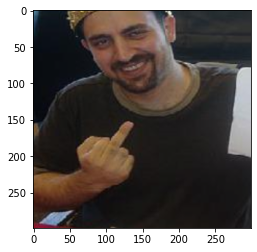

In [24]:
img = Image.open('159.250px-Maddoxtacoma.jpg')
image_to_tensor = transform_test(img).unsqueeze(0)
image_to_tensor = image_to_tensor.to(device)
images = image_to_tensor

outputs = model(image_to_tensor.to(device)).cpu()
_, predicted = outputs.max(1)
pred_val = predicted.item()
print("Predicted class: ",pred_val)
inv_tensor = invTrans(image_to_tensor)
plt.imshow( inv_tensor.detach().cpu().squeeze().permute(1, 2, 0)  )

In [25]:
working_example = region_explainability(image = images, top_n_start = 3, model = model, SMU_class_index = 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


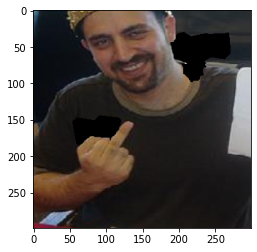

In [26]:
plt.imshow(working_example[0].detach().cpu().squeeze().permute(1, 2, 0))

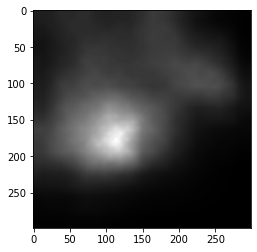

In [16]:
from pytorch_grad_cam import FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
input_tensor = images.to(device)
targets = [ClassifierOutputTarget(0)]
target_layers = [model.layer4[-1]]
cam = FullGrad(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
#visualization = show_cam_on_image(input_tensor, grayscale_cam, use_rgb=T
plt.imshow(grayscale_cam, cmap='gray', vmin=0, vmax=1)

In [17]:
# Use inv_tensor as the original input image, and use grayscale_cam as the attribution map
print(inv_tensor.to('cpu').numpy().shape)
print(grayscale_cam.shape)

(1, 3, 299, 299)
(299, 299)


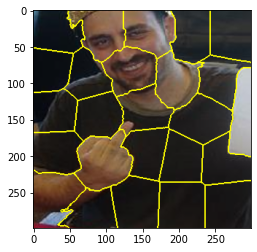

In [28]:
inv_img = inv_tensor
img_np = inv_img.detach().cpu().squeeze().permute(1, 2, 0).numpy()
#plt.imshow(img_np)
# compactness=50
segments_slic = slic(img_np, n_segments=30, compactness=50,
                     start_label=1)
plt.imshow(segmentation.mark_boundaries(img_np, segments_slic))

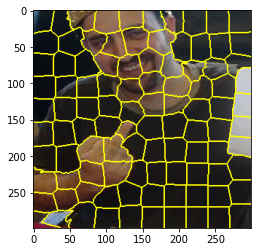

In [29]:
segments_slic = slic(img_np, n_segments=100, compactness=50,
                     start_label=1)
plt.imshow(segmentation.mark_boundaries(img_np, segments_slic))

72


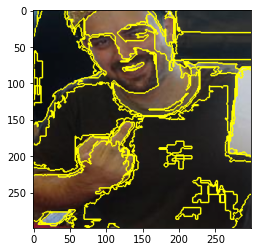

In [30]:
segments_fel = felzenszwalb(img_np, scale=200, sigma=0.5, min_size=50)
print(segments_fel.max())
plt.imshow(segmentation.mark_boundaries(img_np, segments_fel))

221


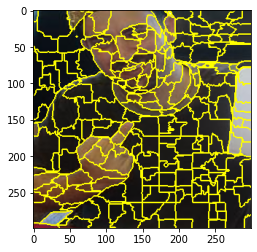

In [37]:
segments_quick = quickshift(img_np, kernel_size=3, max_dist=6, ratio=0.5)
print(segments_quick.max())
plt.imshow(segmentation.mark_boundaries(img_np, segments_quick))

256


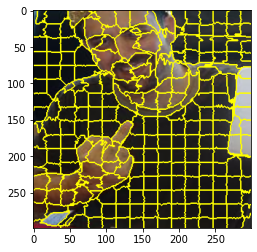

In [41]:
gradient = sobel(rgb2gray(img_np))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)
print(segments_watershed.max())
plt.imshow(segmentation.mark_boundaries(img_np, segments_watershed))

In [30]:
# SLIC with 100 segments and compactness of 50

def region_explainability(image, top_n_start, model, SMU_class_index):
    # Get attribution map
    explainability_mask = get_grayscale_grad_cam(image)
    # Get segment mask
    seg = segmentation_info_slic(image = image, num_segments = 100, compactness = 50)
    # Calculate average attribution in each superpixel
    avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = explainability_mask, segments_slic = seg[1])
    # Sort the regions by average attribution, make num_top_attr = the number of segments in the image
    top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = seg[2])
    features_1 = get_feature_masks(image = image, attributions = top_attrs, segments_slic = seg[1])
    # features_1 gives us a sorted list of feature masks. Element at position 0 is the top attribution region mask
    # Change get_image_versions function
    
    

    
    
    top_n = top_n_start
    score = 1000
    prob = 1
    
    # The computational cost of this loop could be reduced by approximately half
    # Currently I do a counterfactual analysis on top_n regions and expand top_n to top_n + 1
    # This implementation has us redo the counterfactual analysis of the top_n when doing counterfactual analysis on top_n + 1

    while prob > 0.5:
        #image_versions holds the image with regions obfuscated
        image_versions = []
        #num_pixels_changed holds the count of the number of pixels that are obfuscated
        num_pixels_changed = []
        #total_attr_list I think gives us the label of the regions that are being obfuscated
        total_attr_list = []
        #scores holds the score given to the image with regions obfuscated
        scores = []
        
        # features_list contains the features to be analyzed in counterfactual analysis
        # features_list will start with the top 1 region and then go on to top 2 and so on
        features_list = features_1[0:top_n]
        
        powerset_list = list(more_itertools.powerset(features_list))
        powerset_list = [list(ele) for ele in powerset_list]
        num_versions = len(powerset_list)
    
        original_image = invTrans(image)
        image_versions.append(original_image)
        num_pixels_changed.append(0)
        total_attr_list.append(np.zeros((299, 299)))
        
        
        
        for version in range(num_versions - 1):
            obfuscated_image = image
            total_attribution = np.zeros((299, 299))
            total_num_pixels = total_attribution.size
            for mask in range(len(powerset_list[version + 1])):
                total_attribution += powerset_list[version + 1][mask]
            num_changes = np.count_nonzero(total_attribution)
            obfuscated_image = blur_image_from_attribution(image = obfuscated_image,
                                                       attribution_map = total_attribution)
            obfuscated_image = obfuscated_image.to(device)
            obfuscated_image = invTrans(obfuscated_image)
        
            # calculate softmax score of obfuscated image on the unsafe image class
            score = softmax_score(num_total_pixels = total_num_pixels,
                                  num_obf_pixels = num_pixels_changed,
                                  model = model,
                                  image = obfuscated_image,
                                  SMU_class_index = SMU_class_index)
            #print(score)
            
            # if softmax score is less than 0.5, we want to save it as a counterfactual example
            if score < 0.5:
                prob = score
                image_versions.append(obfuscated_image)
                scores.append(score)
                num_pixels_changed.append(num_changes)
                total_attr_list.append(total_attribution)
        
        #print("Regions analyzed", top_n)
        top_n = top_n + 1
    
    
    # Creating an array to hold the information with each counterfactual image we generated
    # It is possible that we could have just one counterfactual image
    unique_image_info = []
    for i in range(len(scores)):
        image_list = []
        image_list.append(image_versions[i])
        image_list.append(num_pixels_changed[i])
        image_list.append(total_num_pixels)
        image_list.append(scores[i])
        image_list.append(total_attr_list[i])
        image_list.append(top_n)
        unique_image_info.append(image_list)
    
    
    # Rank the different counterfactual images
    ranked_images = image_rankings(get_image_versions = unique_image_info)
    
    # Get the best ranked image
    best_masked_image = ranked_images[0]
    
    return best_masked_image

In [34]:
# To test our algorithm with SLIC with 100 regions and 50 compactness
i = 0
n = 0
image_info_list = []
while i < 150:
    torch.manual_seed(0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    images, labels = next(itertools.islice(testloader, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    
    logits = model(images.to(device)).cpu()
    probs = F.softmax(logits, dim=1)
    probs = probs.detach().cpu()
    probs = probs.tolist()[0]
    # Change probs[int] to int = SMU class index
    probs_orig = probs[0]
    #print(probs)
    
    
    if just_label == 0 and predicted ==0:
        print('index:', i+1)
        i += 1
        
        re = region_explainability(image = images, top_n_start = 1, model = model, SMU_class_index = 0)
        
        
        image_info = []
        example = re[0]
        exam_img = good_img_transform(example)
        logits = model(exam_img).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        # Change probs[int] to int = SMU class index
        probs_obf = probs[0]
        #print(probs)
        image_info.append(probs_orig)
        image_info.append(probs_obf)
        
        num_pixels_obf = re[1]
        image_info.append(num_pixels_obf)
        image_info.append(re[5])
        
        image_info_list.append(image_info)
    n += 1

index: 1
index: 2


KeyboardInterrupt: 

In [ ]:
success = 0
total = len(image_info_list)
total_pix = total * 299 * 299
total_obf = 0
total_orig_conf = 0
total_obf_conf = 0
for i in range(len(image_info_list)):
    total_orig_conf += image_info_list[i][0]
    total_obf_conf += image_info_list[i][1]
    total_obf += image_info_list[i][2]


print("Experiment with SLIC with 100 segments and 50 compactness")
print("Average number of regions analyzed: ")
print("Average confidence change: ", ((total_orig_conf - total_obf_conf) / total) )
print("Average obfuscation: ",total_obf / total_pix)

In [ ]:
# felzenszwalb with scale=200, sigma=0.5, min_size=50

def region_explainability(image, top_n_start, model, SMU_class_index):
    # Get attribution map
    explainability_mask = get_grayscale_grad_cam(image)
    # Get segment mask
    seg = segmentation_info_felzenszwalb(image, scale, sigma, min_size)
    # Calculate average attribution in each superpixel
    avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = explainability_mask, segments_slic = seg[1])
    # Sort the regions by average attribution, make num_top_attr = the number of segments in the image
    top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = seg[2])
    features_1 = get_feature_masks(image = image, attributions = top_attrs, segments_slic = seg[1])
    # features_1 gives us a sorted list of feature masks. Element at position 0 is the top attribution region mask
    # Change get_image_versions function
    
    

    
    
    top_n = top_n_start
    score = 1000
    prob = 1
    
    # The computational cost of this loop could be reduced by approximately half
    # Currently I do a counterfactual analysis on top_n regions and expand top_n to top_n + 1
    # This implementation has us redo the counterfactual analysis of the top_n when doing counterfactual analysis on top_n + 1

    while prob > 0.5:
        #image_versions holds the image with regions obfuscated
        image_versions = []
        #num_pixels_changed holds the count of the number of pixels that are obfuscated
        num_pixels_changed = []
        #total_attr_list I think gives us the label of the regions that are being obfuscated
        total_attr_list = []
        #scores holds the score given to the image with regions obfuscated
        scores = []
        
        # features_list contains the features to be analyzed in counterfactual analysis
        # features_list will start with the top 1 region and then go on to top 2 and so on
        features_list = features_1[0:top_n]
        
        powerset_list = list(more_itertools.powerset(features_list))
        powerset_list = [list(ele) for ele in powerset_list]
        num_versions = len(powerset_list)
    
        original_image = invTrans(image)
        image_versions.append(original_image)
        num_pixels_changed.append(0)
        total_attr_list.append(np.zeros((299, 299)))
        
        
        
        for version in range(num_versions - 1):
            obfuscated_image = image
            total_attribution = np.zeros((299, 299))
            total_num_pixels = total_attribution.size
            for mask in range(len(powerset_list[version + 1])):
                total_attribution += powerset_list[version + 1][mask]
            num_changes = np.count_nonzero(total_attribution)
            obfuscated_image = blur_image_from_attribution(image = obfuscated_image,
                                                       attribution_map = total_attribution)
            obfuscated_image = obfuscated_image.to(device)
            obfuscated_image = invTrans(obfuscated_image)
        
            # calculate softmax score of obfuscated image on the unsafe image class
            score = softmax_score(num_total_pixels = total_num_pixels,
                                  num_obf_pixels = num_pixels_changed,
                                  model = model,
                                  image = obfuscated_image,
                                  SMU_class_index = SMU_class_index)
            #print(score)
            
            # if softmax score is less than 0.5, we want to save it as a counterfactual example
            if score < 0.5:
                prob = score
                image_versions.append(obfuscated_image)
                scores.append(score)
                num_pixels_changed.append(num_changes)
                total_attr_list.append(total_attribution)
        
        #print("Regions analyzed", top_n)
        top_n = top_n + 1
    
    
    # Creating an array to hold the information with each counterfactual image we generated
    # It is possible that we could have just one counterfactual image
    unique_image_info = []
    for i in range(len(scores)):
        image_list = []
        image_list.append(image_versions[i])
        image_list.append(num_pixels_changed[i])
        image_list.append(total_num_pixels)
        image_list.append(scores[i])
        image_list.append(total_attr_list[i])
        image_list.append(top_n)
        unique_image_info.append(image_list)
    
    
    # Rank the different counterfactual images
    ranked_images = image_rankings(get_image_versions = unique_image_info)
    
    # Get the best ranked image
    best_masked_image = ranked_images[0]
    
    return best_masked_image

In [ ]:
# To test our algorithm with SLIC with 100 regions and 50 compactness
i = 0
n = 0
image_info_list = []
while i < 150:
    torch.manual_seed(0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    images, labels = next(itertools.islice(testloader, n, None))
    just_label = labels.item()
    
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    predicted = predicted.cpu().item()
    #n += 1
    #print()
    #print(predicted)
    
    logits = model(images.to(device)).cpu()
    probs = F.softmax(logits, dim=1)
    probs = probs.detach().cpu()
    probs = probs.tolist()[0]
    # Change probs[int] to int = SMU class index
    probs_orig = probs[0]
    #print(probs)
    
    
    if just_label == 0 and predicted ==0:
        print('index:', i+1)
        i += 1
        
        re = region_explainability(image = images, top_n_start = 1, model = model, SMU_class_index = 0)
        
        
        image_info = []
        example = re[0]
        exam_img = good_img_transform(example)
        logits = model(exam_img).cpu()
        probs = F.softmax(logits, dim=1)
        probs = probs.detach().cpu()
        probs = probs.tolist()[0]
        # Change probs[int] to int = SMU class index
        probs_obf = probs[0]
        #print(probs)
        image_info.append(probs_orig)
        image_info.append(probs_obf)
        
        num_pixels_obf = re[1]
        image_info.append(num_pixels_obf)
        
        image_info_list.append(image_info)
    n += 1

In [ ]:
success = 0
total = len(image_info_list)
total_pix = total * 299 * 299
total_obf = 0
total_orig_conf = 0
total_obf_conf = 0
for i in range(len(image_info_list)):
    total_orig_conf += image_info_list[i][0]
    total_obf_conf += image_info_list[i][1]
    total_obf += image_info_list[i][2]


print("Experiment with SLIC with 100 segments and 50 compactness")
print("Average number of regions analyzed: ")
print("Average confidence change: ", ((total_orig_conf - total_obf_conf) / total) )
print("Average obfuscation: ",total_obf / total_pix)